In [1]:
# Standard library imports
import itertools as it
import math
from operator import itemgetter

# Third-party library imports
import bar_chart_race as bcr
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
# Cleaned results used for Part 1
results_df = pd.read_csv('../data/processed/cleaned_results_data.csv')
# Merged results used for Part 2 and 3
merged_df = pd.read_csv('../data/processed/integrated_merged_data.csv')
# Euro 2024 team groups and names for Part 3
euro_team_names_df = pd.read_csv('../data/processed/team_names_data.csv')

## Part 1

##### 1) Which two teams played the first ever game in the UEFA Euros Competition?

In [3]:
# For this analysis, qualification will not be included
euro_results = results_df[results_df['tournament'].str.contains('uefa euro', case=False) & ~results_df['tournament'].str.contains('qualification', case=False)]
euro_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,winning_team,losing_team,total_goals,year,decade
4941,1960-07-06,Czechoslovakia,Russia,0,3,UEFA Euro,Marseille,France,True,A,Russia,Czechoslovakia,3,1960,1960
4942,1960-07-06,France,Yugoslavia,4,5,UEFA Euro,Paris,France,False,A,Yugoslavia,France,9,1960,1960
4944,1960-07-09,France,Czechoslovakia,0,2,UEFA Euro,Marseille,France,False,A,Czechoslovakia,France,2,1960,1960
4949,1960-07-10,Russia,Yugoslavia,2,1,UEFA Euro,Paris,France,True,H,Russia,Yugoslavia,3,1960,1960
5890,1964-06-17,Denmark,Russia,0,3,UEFA Euro,Barcelona,Spain,True,A,Russia,Denmark,3,1964,1960


##### 2) Which European city/country has hosted the most matches throughout the years?

In [4]:
country_appearances = euro_results['country'].value_counts()
country_appearances

country
France         70
England        39
Portugal       31
Italy          23
Netherlands    20
Belgium        19
Germany        19
Austria        16
Ukraine        16
Poland         15
Switzerland    15
Sweden         15
Spain           8
Russia          7
Yugoslavia      4
Denmark         4
Romania         4
Scotland        4
Hungary         4
Azerbaijan      3
Wales           1
Name: count, dtype: int64

In [5]:
euro_results.loc[(euro_results['country'] == "England"),'country'] = 'United Kingdom'
euro_results.loc[(euro_results['country'] == "Scotland"),'country'] = 'United Kingdom'
euro_results.loc[(euro_results['country'] == "Wales"),'country'] = 'United Kingdom'
country_appearances = euro_results.groupby('country').size().reset_index(name='count')
country_appearances = country_appearances.sort_values('count', ascending=False)
# print(country_appearances)

fig = px.choropleth(country_appearances, locations='country',
                    locationmode='country names',
                    color='count',
                    hover_name='country',
                    color_continuous_scale=px.colors.sequential.thermal_r,
                    scope='europe')
fig.update_layout(margin=dict(l=20, r=0, b=0, t=70, pad=0),
                  paper_bgcolor='white',
                  height=700,
                  title_text='Number of appearances of each country in Euro',
                  font_size=18)
fig.show()

##### Now by city

In [6]:
city_appearances = euro_results['city'].value_counts()
most_appearances_city = city_appearances.idxmax()
pd.set_option('display.max_rows', None)
city_appearances

city
London               14
Rome                 11
Marseille            10
Lisbon               10
Amsterdam             9
Lyon                  9
Paris                 9
Porto                 8
Brussels              7
Vienna                7
Saint Petersburg      7
Saint-Denis           7
Basel                 6
Lens                  6
Villeneuve-d'Ascq     6
Saint-Étienne         6
Munich                6
Warsaw                5
Gothenburg            5
Manchester            5
Naples                5
Rotterdam             5
Donetsk               5
Kyiv                  5
Bordeaux              5
Gdańsk                4
Bruges                4
Solna                 4
Nice                  4
Toulouse              4
Copenhagen            4
Budapest              4
Liège                 4
Bucharest             4
Birmingham            4
Seville               4
Liverpool             4
Glasgow               4
Klagenfurt            3
Lviv                  3
Berne                 3
Zürich     

In [7]:
# Set up hosted city map
min_lon, max_lon = -15, 40
min_lat, max_lat = 25, 65

m = folium.Map(
    max_bounds=True,
    location=[53, 15],
    zoom_start=5,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
)

folium.CircleMarker([max_lat, min_lon], tooltip="Upper Left Corner").add_to(m)
folium.CircleMarker([min_lat, min_lon], tooltip="Lower Left Corner").add_to(m)
folium.CircleMarker([min_lat, max_lon], tooltip="Lower Right Corner").add_to(m)
folium.CircleMarker([max_lat, max_lon], tooltip="Upper Right Corner").add_to(m)

In [8]:
# Initialize geolocator
geolocator = Nominatim(user_agent="name")

# Initialize geolocator with rate limiting
geocode_with_delay = RateLimiter(geolocator.geocode, min_delay_seconds=1)

city_names = []
latitudes = []
longitudes = []
value_counts = []

for city in city_appearances.index:
    try:
        location = geocode_with_delay(city)
        if location:
            city_names.append(city)
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
            value_counts.append(city_appearances[city])
        else:
            print(f"No location found for {city}")
    except Exception as e:
        print(f"Error geocoding {city}: {e}")

city_data = pd.DataFrame({
    'City': city_names,
    'Latitude': latitudes,
    'Longitude': longitudes,
    'Value_Count': value_counts
})

print(city_data)


                 City   Latitude  Longitude  Value_Count
0              London  51.507446  -0.127765           14
1                Rome  41.893320  12.482932           11
2           Marseille  43.296174   5.369953           10
3              Lisbon  38.707751  -9.136592           10
4           Amsterdam  52.373080   4.892453            9
5                Lyon  45.757814   4.832011            9
6               Paris  48.858890   2.320041            9
7               Porto  41.149451  -8.610788            8
8            Brussels  50.846557   4.351697            7
9              Vienna  48.208354  16.372504            7
10   Saint Petersburg  59.960674  30.158655            7
11        Saint-Denis  48.935773   2.358023            7
12              Basel  47.558108   7.587826            6
13               Lens  50.429172   2.831980            6
14  Villeneuve-d'Ascq  50.619317   3.131400            6
15      Saint-Étienne  45.440147   4.387306            6
16             Munich  48.13710

In [9]:
# Add marker one by one on the map and account for Mercator deformation
for city in city_data.itertuples():
    local_deformation = math.cos(city.Latitude * math.pi / 180)
    folium.Circle(
        location=[city.Latitude, city.Longitude],
        popup='%s (%.1f)' % (city.City, city.Value_Count),
        radius=city.Value_Count * 20000.0 * local_deformation,
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(m)

# Show map
m

##### 3) Who are the best attacking and defending teams throughout different eras?

In [10]:
# Calculate total goals scored and conceded by each team
goals_scored = euro_results.groupby('home_team')['home_score'].sum() + euro_results.groupby('away_team')['away_score'].sum()
goals_conceded = euro_results.groupby('home_team')['away_score'].sum() + euro_results.groupby('away_team')['home_score'].sum()

# Calculate goal difference
goal_difference = goals_scored - goals_conceded

# Sort teams based on goals scored and conceded
sorted_attacking_teams = goals_scored.sort_values(ascending=False)
sorted_defending_teams = goals_conceded.sort_values()

# Get top 10 attacking and defending teams
top_10_attacking_teams = sorted_attacking_teams.head(10)
top_10_defending_teams = sorted_defending_teams.head(10)

print("Top 10 Attacking Teams:")
print(top_10_attacking_teams)
print("\nTop 10 Defending Teams:")
print(top_10_defending_teams)

Top 10 Attacking Teams:
Germany           78.0
France            69.0
Spain             68.0
Netherlands       65.0
Portugal          56.0
Italy             52.0
England           51.0
Denmark           42.0
Russia            40.0
Czech Republic    36.0
dtype: float64

Top 10 Defending Teams:
Norway               1.0
Albania              3.0
Northern Ireland     3.0
Finland              3.0
Latvia               5.0
Slovenia             5.0
Iceland              9.0
Scotland            10.0
Czechoslovakia      10.0
Wales               12.0
dtype: float64


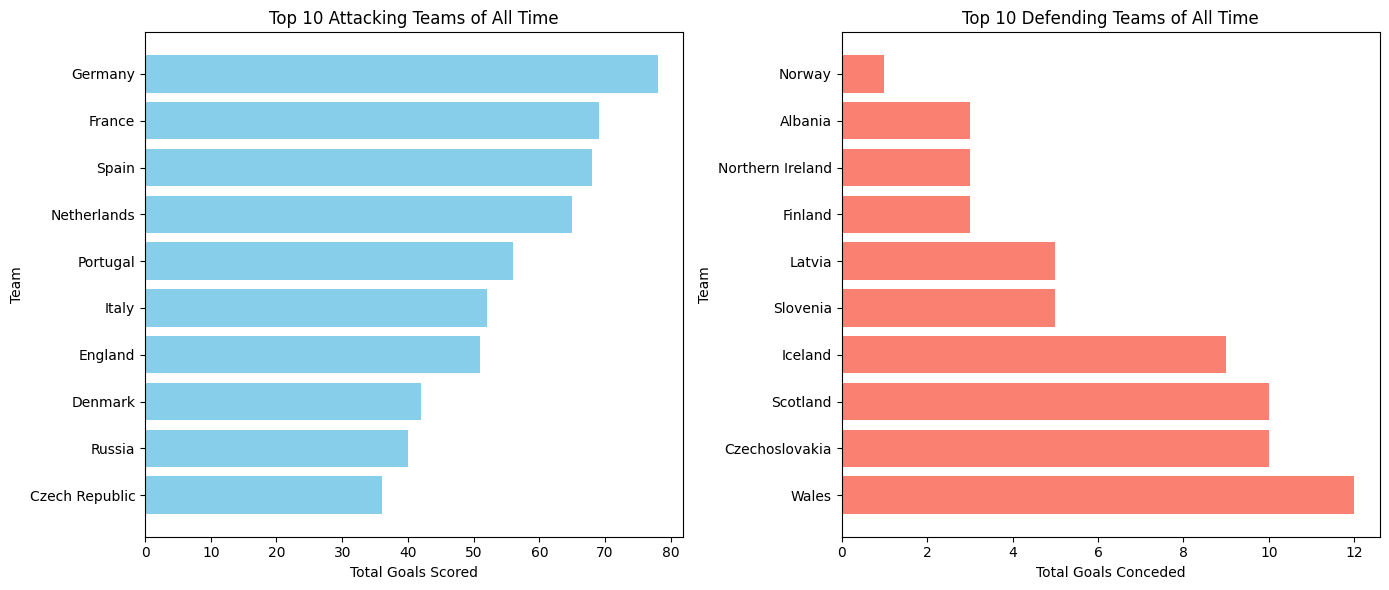

In [11]:
# Define top 10 attacking teams and corresponding goals scored
top_attacking_teams = top_10_attacking_teams.index
top_attacking_goals = top_10_attacking_teams.values

# Reverse order to plot from largest to smallest
top_attacking_teams = top_attacking_teams[::-1]
top_attacking_goals = top_attacking_goals[::-1]

# Define top 10 defending teams and corresponding goals conceded
top_defending_teams = top_10_defending_teams.index
top_defending_goals = top_10_defending_teams.values

# Reverse order of defending teams and goals to plot from lowest to highest
top_defending_teams = top_defending_teams[::-1]
top_defending_goals = top_defending_goals[::-1]

# Create figure and axis for plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot top attacking teams
axes[0].barh(top_attacking_teams, top_attacking_goals, color='skyblue')
axes[0].set_title('Top 10 Attacking Teams of All Time')
axes[0].set_xlabel('Total Goals Scored')
axes[0].set_ylabel('Team')

# Plot top defending teams
axes[1].barh(top_defending_teams, top_defending_goals, color='salmon')
axes[1].set_title('Top 10 Defending Teams of All Time')
axes[1].set_xlabel('Total Goals Conceded')
axes[1].set_ylabel('Team')

plt.tight_layout()
plt.show()


##### Now by each decade

In [12]:
# Convert 'date' to datetime
euro_results['date'] = pd.to_datetime(euro_results['date'])

# Get unique years from the 'date' column
unique_years = euro_results['date'].dt.year.unique()

for year in unique_years:
    year_data = euro_results[euro_results['date'].dt.year == year]
    
    goals_scored_year = year_data.groupby('home_team')['home_score'].sum() + year_data.groupby('away_team')['away_score'].sum()
    goals_conceded_year = year_data.groupby('home_team')['away_score'].sum() + year_data.groupby('away_team')['home_score'].sum()

    goal_difference_year = goals_scored_year - goals_conceded_year

    sorted_attacking_teams_year = goals_scored_year.sort_values(ascending=False)
    sorted_defending_teams_year = goals_conceded_year.sort_values()
    
    top_10_attacking_teams_year = sorted_attacking_teams_year.head(10)
    top_10_defending_teams_year = sorted_defending_teams_year.head(10)

    
    print(f"\nTop 10 Attacking Teams in {year}:")
    print(top_10_attacking_teams_year)
    print(f"\nTop 10 Defending Teams in {year}:")
    print(top_10_defending_teams_year)



Top 10 Attacking Teams in 1960:
Russia            5.0
Czechoslovakia    2.0
France            NaN
Yugoslavia        NaN
dtype: float64

Top 10 Defending Teams in 1960:
Russia            1.0
Czechoslovakia    3.0
France            NaN
Yugoslavia        NaN
dtype: float64

Top 10 Attacking Teams in 1964:
Hungary    4.0
Denmark    1.0
Russia     NaN
Spain      NaN
dtype: float64

Top 10 Defending Teams in 1964:
Hungary    3.0
Denmark    6.0
Russia     NaN
Spain      NaN
dtype: float64

Top 10 Attacking Teams in 1968:
England      NaN
Italy        NaN
Russia       NaN
Yugoslavia   NaN
dtype: float64

Top 10 Defending Teams in 1968:
England      NaN
Italy        NaN
Russia       NaN
Yugoslavia   NaN
dtype: float64

Top 10 Attacking Teams in 1972:
Germany    5.0
Hungary    1.0
Belgium    NaN
Russia     NaN
dtype: float64

Top 10 Defending Teams in 1972:
Germany    1.0
Hungary    3.0
Belgium    NaN
Russia     NaN
dtype: float64

Top 10 Attacking Teams in 1976:
Czechoslovakia   NaN
Germany   

/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/3612430647.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
# Convert 'date' to datetime
euro_results['date'] = pd.to_datetime(euro_results['date'])

# Extract year from 'date' column
euro_results['year'] = euro_results['date'].dt.year

# Combine home_team and away_team data to get all teams with goals scored
teams_home_scored = euro_results[['year', 'home_team', 'home_score']].rename(columns={'home_team': 'team', 'home_score': 'score'})
teams_away_scored = euro_results[['year', 'away_team', 'away_score']].rename(columns={'away_team': 'team', 'away_score': 'score'})

# Combine for all teams with goals conceded
teams_home_conceded = euro_results[['year', 'home_team', 'away_score']].rename(columns={'home_team': 'team', 'away_score': 'score'})
teams_away_conceded = euro_results[['year', 'away_team', 'home_score']].rename(columns={'away_team': 'team', 'home_score': 'score'})

# Concatenate teams with goals scored and conceded
teams_scored = pd.concat([teams_home_scored, teams_away_scored])
teams_conceded = pd.concat([teams_home_conceded, teams_away_conceded])

# Pivot DataFrames to get the desired format for goals scored and conceded
pivot_df_scored = pd.pivot_table(teams_scored, index='year', columns='team', values='score', aggfunc='sum', fill_value=0)
pivot_df_conceded = pd.pivot_table(teams_conceded, index='year', columns='team', values='score', aggfunc='sum', fill_value=0)

# Combine goals scored and conceded DataFrames
combined_df = pd.concat([pivot_df_scored, pivot_df_conceded], keys=['goals_scored', 'goals_conceded'], axis=1)

print(combined_df)

     goals_scored                                                  \
team      Albania Austria Belgium Bulgaria Croatia Czech Republic   
year                                                                
1960            0       0       0        0       0              0   
1964            0       0       0        0       0              0   
1968            0       0       0        0       0              0   
1972            0       0       3        0       0              0   
1976            0       0       0        0       0              0   
1980            0       0       4        0       0              0   
1984            0       0       4        0       0              0   
1988            0       0       0        0       0              0   
1992            0       0       0        0       0              0   
1996            0       0       0        3       5              7   
2000            0       0       2        0       0              3   
2004            0       0       0 

/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/1680032129.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/1680032129.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# Racing bar chart for Goals Scored by Nation
bcr.bar_chart_race(df=pivot_df_scored, n_bars = 10, title='Goals Scored by Nation', period_length = 1000, dpi =144, filter_column_colors=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:889: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:286: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:287: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



In [15]:
# Racing bar chart for goals conceded by nation
bcr.bar_chart_race(df=pivot_df_conceded, n_bars = 10, title='Goals Conceded by Nation', period_length = 1000, dpi =144, filter_column_colors=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:889: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:286: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bar_chart_race/_make_chart.py:287: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



## Part 2

##### 1) Do the teams that are successful in the World Cup also perform well in the Euros and/or vice versa?

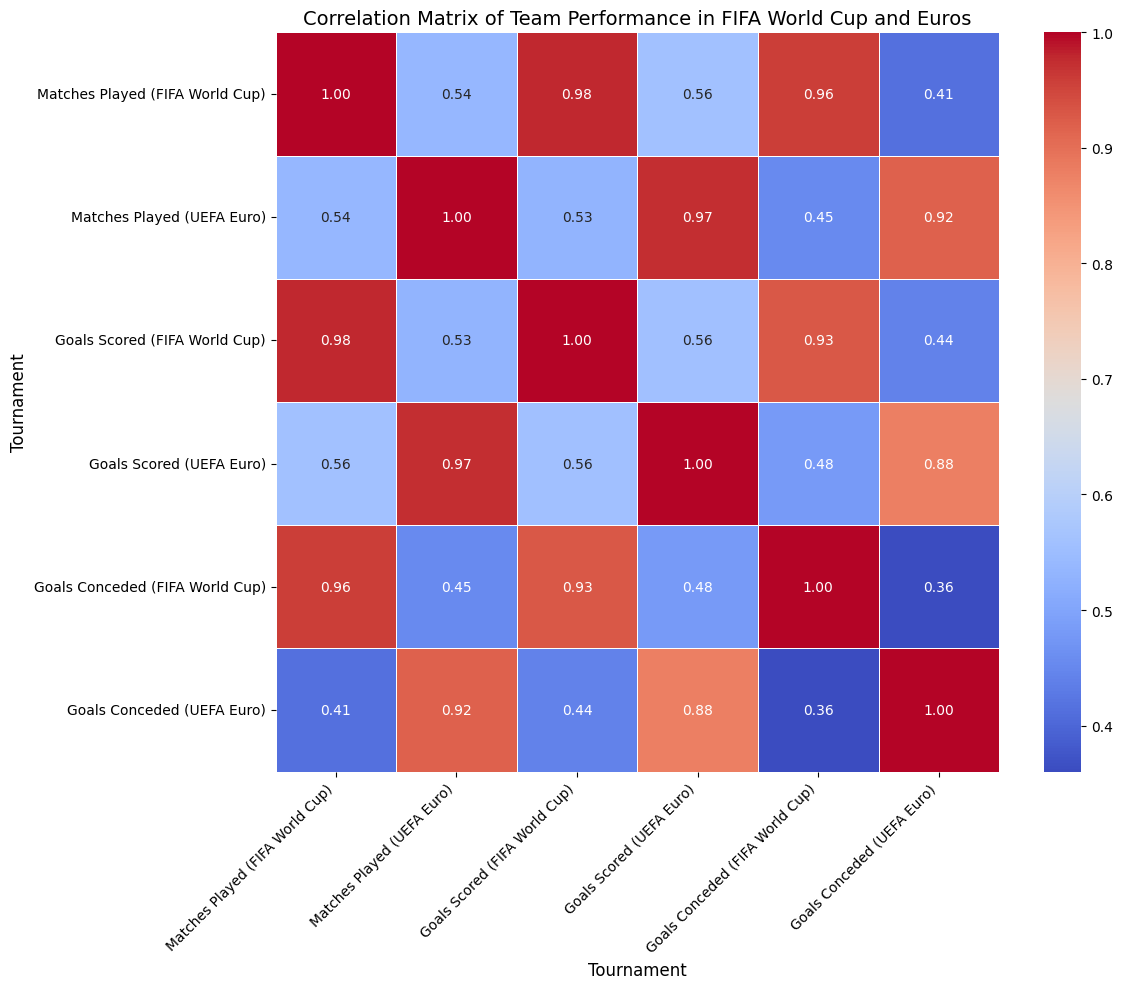

In [16]:
wc_results = results_df[results_df['tournament'].str.contains('fifa world', case=False) & ~results_df['tournament'].str.contains('qualification', case=False)]

# Concatenate the datasets
all_matches_df = pd.concat([euro_results, wc_results])

# Feature Engineering
all_matches_df['match_outcome'] = np.where(all_matches_df['home_score'] > all_matches_df['away_score'], 'win',
                                           np.where(all_matches_df['home_score'] < all_matches_df['away_score'], 'lose', 'draw'))

# Grouping and Aggregation
team_performance = all_matches_df.groupby(['tournament', 'home_team']).agg({
    'match_outcome': 'count',  # Total matches played
    'home_score': 'sum',       # Total goals scored at home
    'away_score': 'sum'        # Total goals conceded away
}).reset_index()

# Filter for relevant columns
team_performance = team_performance[['tournament', 'home_team', 'match_outcome', 'home_score', 'away_score']]

# Pivot the table to get separate columns for home and away performance
team_performance_pivot = team_performance.pivot(index='home_team', columns='tournament', values=['match_outcome', 'home_score', 'away_score']).fillna(0)

# Calculate correlation coefficients
correlation_matrix = team_performance_pivot.corr()

# Define custom tournament labels for the heatmap
tournament_labels = {
    ('match_outcome', 'FIFA World Cup'): 'Matches Played (FIFA World Cup)',
    ('home_score', 'FIFA World Cup'): 'Goals Scored (FIFA World Cup)',
    ('away_score', 'FIFA World Cup'): 'Goals Conceded (FIFA World Cup)',
    ('match_outcome', 'UEFA Euro'): 'Matches Played (UEFA Euro)',
    ('home_score', 'UEFA Euro'): 'Goals Scored (UEFA Euro)',
    ('away_score', 'UEFA Euro'): 'Goals Conceded (UEFA Euro)',
}

# Get the column labels from the correlation matrix
column_labels = correlation_matrix.columns

# Update the labels for 'home_score' column in the 'FIFA World Cup' tournament
for idx, col_label in enumerate(column_labels):
    if col_label[0] == 'home_score' and col_label[1] == 'fifa':
        column_labels[idx] = ('home_score', 'fifa')

# Define custom column labels for x-axis and y-axis
x_labels = [tournament_labels[col] if col in tournament_labels else col for col in column_labels]
y_labels = [tournament_labels[col] if col in tournament_labels else col for col in correlation_matrix.index]

# Plot the heatmap with custom labels
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=x_labels, yticklabels=y_labels, linewidths=0.5)
plt.title('Correlation Matrix of Team Performance in FIFA World Cup and Euros', fontsize=14)
plt.xlabel('Tournament', fontsize=12)
plt.ylabel('Tournament', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout() 
plt.show()

##### 2) Is the Euros competition the hardest continental competition to win regarding the number of teams in high rankings?

/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/1049232764.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




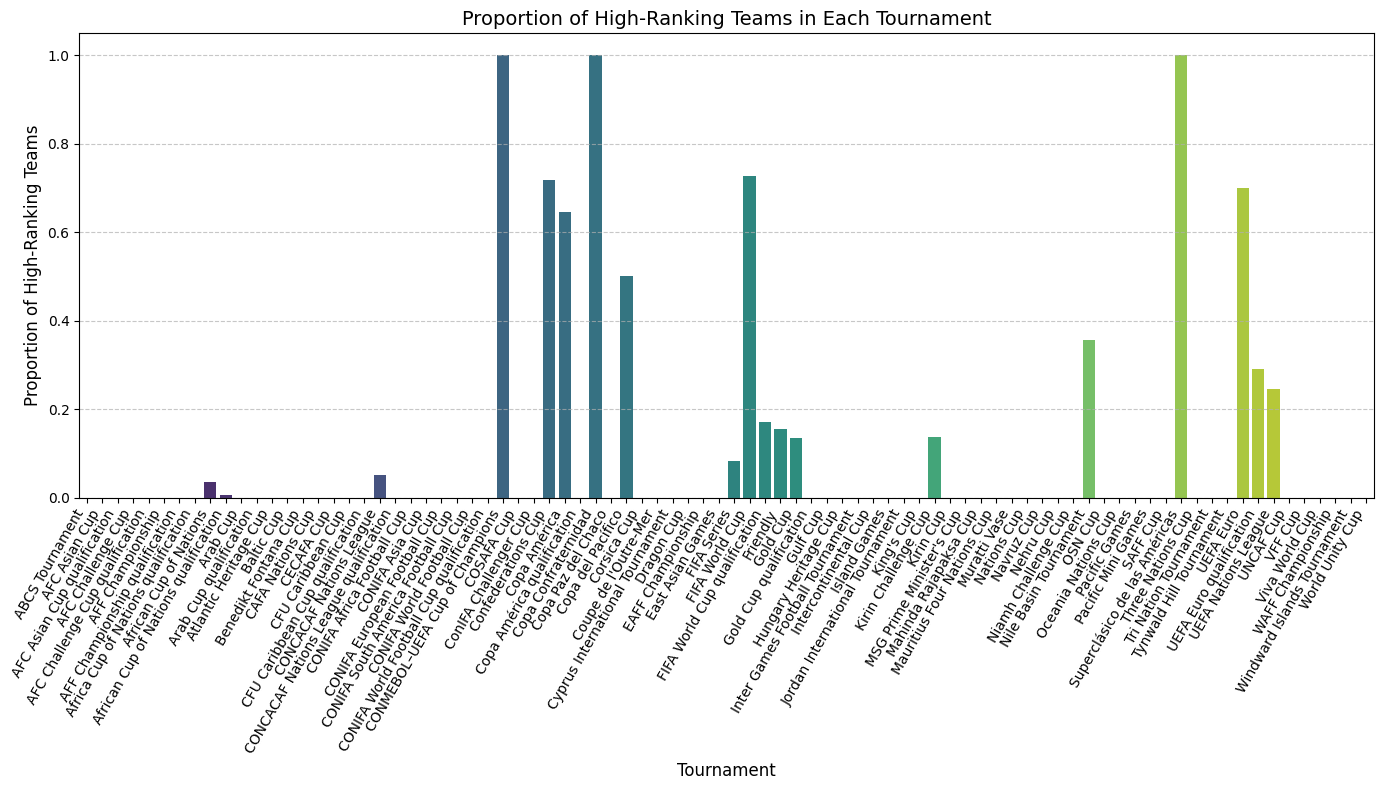

Chi-square statistic: 2186.723240029515
p-value: 0.000


In [17]:
# Statistical Testing
contingency_table = pd.crosstab(merged_df['tournament'], merged_df['high_ranking'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Group merged_data by tournament and high_ranking column and calculate the mean
mean_high_ranking = merged_df.groupby('tournament')['high_ranking'].mean().reset_index()

# Plotting with Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(data=mean_high_ranking, x='tournament', y='high_ranking', palette='viridis')
plt.xlabel('Tournament', fontsize=12)
plt.ylabel('Proportion of High-Ranking Teams', fontsize=12)
plt.title('Proportion of High-Ranking Teams in Each Tournament', fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p:.3f}')

In [18]:
# Sort the mean_high_ranking DataFrame by 'high_ranking' column in descending order
mean_high_ranking_sorted = mean_high_ranking.sort_values(by='high_ranking', ascending=False)

# Select the top 10 tournaments with the highest-ranking teams
top_20_tournaments = mean_high_ranking_sorted.head(20)

# Display the top 10 tournaments
print(top_20_tournaments)

                              tournament  high_ranking
27        CONMEBOL–UEFA Cup of Champions      1.000000
71          Superclásico de las Américas      1.000000
33                   Copa Confraternidad      1.000000
43                        FIFA World Cup      0.726562
30                    Confederations Cup      0.718750
75                             UEFA Euro      0.699248
31                          Copa América      0.644928
35                     Copa del Pacífico      0.500000
65                 Nile Basin Tournament      0.357143
76               UEFA Euro qualification      0.291339
77                   UEFA Nations League      0.244726
44          FIFA World Cup qualification      0.171259
45                              Friendly      0.154062
55                   Kirin Challenge Cup      0.136364
46                              Gold Cup      0.134021
42                           FIFA Series      0.083333
19               CONCACAF Nations League      0.050955
8         

##### 3) Does the hosted country have an advantage in terms of advancing further into the tournament?

There is no significant difference in performance between hosted and non-hosted countries.
0.5791589258172547


/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/2413415102.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




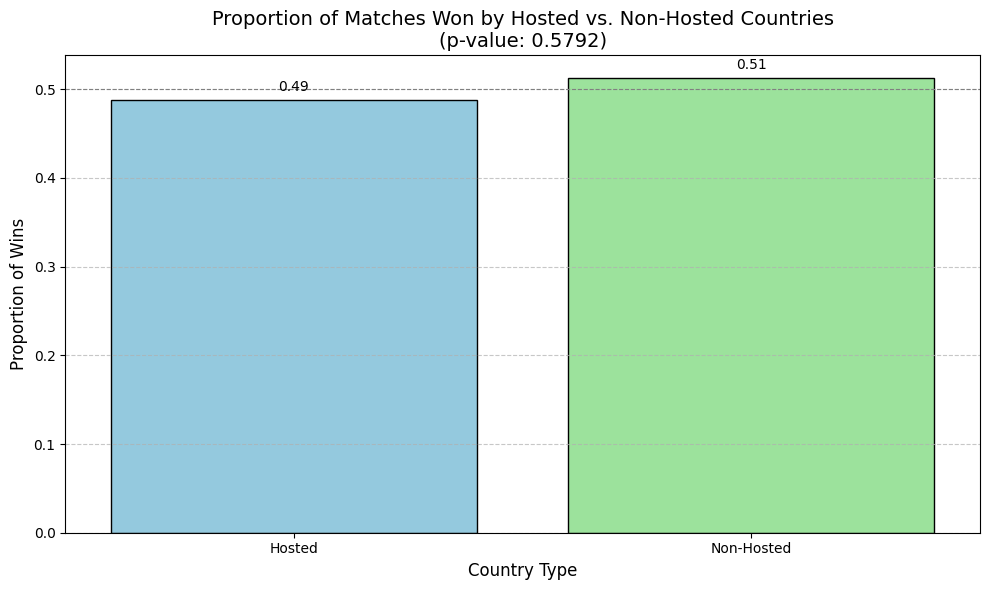

In [19]:
# Filter matches where the home team is the hosted country
hosted_matches = euro_results[euro_results['home_team'] == euro_results['country']]

# Analyze performance of hosted matches compared to non-hosted matches
# For example, calculate the proportion of matches won by hosted country

# Calculate the proportion of matches won by the hosted country
proportion_wins_hosted = hosted_matches[hosted_matches['outcome'] == 'H'].shape[0] / hosted_matches.shape[0]

# Compare with the proportion of matches won by non-hosted countries
proportion_wins_non_hosted = 1 - proportion_wins_hosted

# Perform statistical testing (example using chi-square test)
contingency_table = pd.crosstab(euro_results['country'], euro_results['outcome'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Interpret the results
if p < 0.05:
    print("There is evidence of a significant difference in performance between hosted and non-hosted countries.")
else:
    print("There is no significant difference in performance between hosted and non-hosted countries.")

print(p)

# Create a DataFrame for visualization
data = pd.DataFrame({'Group': ['Hosted', 'Non-Hosted'],
                     'Proportion of Wins': [proportion_wins_hosted, proportion_wins_non_hosted]})

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Group', y='Proportion of Wins', palette=['skyblue', 'lightgreen'], edgecolor='black')

# Add data labels
for index, row in data.iterrows():
    plt.text(index, row['Proportion of Wins'] + 0.01, f'{row["Proportion of Wins"]:.2f}', color='black', ha='center')

# Add horizontal line at y=0.5
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Country Type', fontsize=12)
plt.ylabel('Proportion of Wins', fontsize=12)
plt.title('Proportion of Matches Won by Hosted vs. Non-Hosted Countries\n(p-value: {:.4f})'.format(p), fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

There is no significant difference in performance between hosted and non-hosted countries.
P-value: 0.5792


/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/2696804795.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




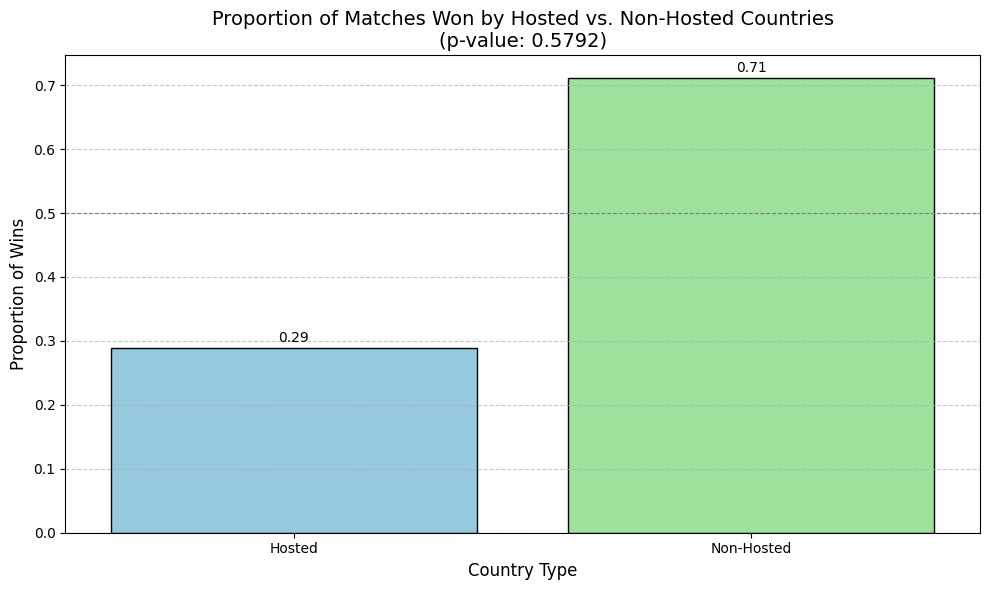

In [20]:
# Function to perform sensitivity analysis
def sensitivity_analysis(euro_results, outcome='H', significance_level=0.05):
    # Filter matches based on outcome (default: wins by hosted country)
    hosted_matches = euro_results[euro_results['outcome'] == outcome]

    # Calculate the proportion of matches won by the hosted country
    proportion_wins_hosted = hosted_matches[hosted_matches['country'] == hosted_matches['home_team']].shape[0] / hosted_matches.shape[0]

    # Compare with the proportion of matches won by non-hosted countries
    proportion_wins_non_hosted = 1 - proportion_wins_hosted

    # Perform statistical testing (chi-square test)
    contingency_table = pd.crosstab(euro_results['country'], euro_results['outcome'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Interpret the results
    if p < significance_level:
        print("There is evidence of a significant difference in performance between hosted and non-hosted countries.")
    else:
        print("There is no significant difference in performance between hosted and non-hosted countries.")

    print(f"P-value: {p:.4f}")

    # Create a DataFrame for visualization
    data = pd.DataFrame({'Group': ['Hosted', 'Non-Hosted'],
                         'Proportion of Wins': [proportion_wins_hosted, proportion_wins_non_hosted]})

    # Plotting with Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data, x='Group', y='Proportion of Wins', palette=['skyblue', 'lightgreen'], edgecolor='black')

    # Add data labels
    for index, row in data.iterrows():
        plt.text(index, row['Proportion of Wins'] + 0.01, f'{row["Proportion of Wins"]:.2f}', color='black', ha='center')

    # Add horizontal line at y=0.5
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)

    plt.xlabel('Country Type', fontsize=12)
    plt.ylabel('Proportion of Wins', fontsize=12)
    plt.title('Proportion of Matches Won by Hosted vs. Non-Hosted Countries\n(p-value: {:.4f})'.format(p), fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage
sensitivity_analysis(euro_results, outcome='H', significance_level=0.05)

## Part 3

##### Projecting the winner of Euro 2024
###### Note: Part 3 required extra data integration as shown below

In [21]:
df = merged_df

In [22]:
# Function to determine the result of a match based on home and away scores
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

# Adding columns for match results and points awarded to home and away teams
results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

# Adding match result columns and points columns based on match results
df[["result", "home_team_points", "away_team_points"]] = results

# Calculating rank difference, score difference, and points per rank for each match
df["rank_dif"] = df["home_rank"] - df["away_rank"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["away_rank"]
df["points_away_by_rank"] = df["away_team_points"]/df["home_rank"]

# Creating separate DataFrames for home and away teams
home_team = df[["date", "home_team", "home_score", "away_score", "home_rank", "away_rank", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]
away_team = df[["date", "away_team", "away_score", "home_score", "away_rank", "home_rank", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

# Renaming columns in the home_team and away_team DataFrames
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]
away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

# Combining home_team and away_team DataFrames
team_stats = home_team._append(away_team)#.sort_values("date")

# Used to calculate features for simulation
team_stats_raw = team_stats.copy()

home_team.head()

,date,team,score,suf_score,rank,suf_rank,result,rank_dif,points_by_rank,team_points
0,2009-09-04,Malta,0,2,139.0,111.0,1,28.0,0.000000,0
1,2009-09-05,Angola,1,1,91.0,79.0,2,12.0,0.012658,1
2,2009-09-05,Argentina,1,3,7.0,NaN,1,NaN,NaN,0
3,2009-09-05,Armenia,0,2,125.0,45.0,1,80.0,0.000000,0
4,2009-09-05,Austria,3,1,69.0,162.0,0,-93.0,0.018519,3


In [23]:
# Empty list to store computed statistics for each team
stats_val = []

# Iterating over each row in the team_stats DataFrame to compute team statistics
for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]

    # Filtering past games of the team and sorting them by date in descending order
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)

    # Selecting the last 5 games
    last5 = past_games.head(5)
    
    # Computing mean goals scored for all past games and last 5 games
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    # Computing mean goals conceded for all past games and last 5 games
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    # Computing mean opponent rank for all past games and last 5 games
    rank = past_games["suf_rank"].mean()
    rank_l5 = last5["suf_rank"].mean()
    
    # Computing mean game points for all past games and last 5 games
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    # Computing mean game points per rank for all past games and last 5 games
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    # Appending computed statistics to the stats_val list
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, gp, gp_l5, gp_rank, gp_rank_l5])

# Column names for the computed statistics DataFrame
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

# Creating a DataFrame from the computed statistics
stats_df = pd.DataFrame(stats_val, columns=stats_cols)

# Combining the original team statistics DataFrame and the computed statistics DataFrame
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

# Separating home team statistics and away team statistics
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

# Selecting the last 12 columns (computed statistics) of the home_team_stats DataFrame
home_team_stats.columns[-12:]



Index(['points_by_rank', 'team_points', 'goals_mean', 'goals_mean_l5',
       'goals_suf_mean', 'goals_suf_mean_l5', 'rank_mean', 'rank_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [24]:
# Selecting only the last 12 columns (computed statistics) of the home_team_stats and away_team_stats DataFrames
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [25]:
# Renaming columns of home_team_stats and away_team_stats DataFrames with "home_" and "away_" prefixes
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [26]:
# Concatenating home_team_stats and away_team_stats DataFrames horizontally, reset index for away_team_stats, and ignoring index for the concatenation
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [27]:
# Concatenating the original DataFrame (df) and the match_stats DataFrame horizontally, reset index for match_stats, and ignoring index for the concatenation
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [28]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'outcome', 'winning_team',
       'losing_team', 'total_goals', 'year', 'decade', 'first_shooter',
       'home_rank', 'nation_x', 'confederation_x', 'points_x', 'away_rank',
       'nation_y', 'confederation_y', 'points_y', 'date.1', 'high_ranking',
       'result', 'home_team_points', 'away_team_points', 'rank_dif', 'sg',
       'points_home_by_rank', 'points_away_by_rank', 'home_points_by_rank',
       'home_team_points', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_points_by_rank',
       'away_team_points', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_

In [29]:
# Function to check if a match is a friendly match based on the tournament type
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

full_df = pd.get_dummies(full_df, columns=["is_friendly"])

full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'outcome', 'winning_team',
       'losing_team', 'total_goals', 'year', 'decade', 'first_shooter',
       'home_rank', 'nation_x', 'confederation_x', 'points_x', 'away_rank',
       'nation_y', 'confederation_y', 'points_y', 'date.1', 'high_ranking',
       'result', 'home_team_points', 'away_team_points', 'rank_dif', 'sg',
       'points_home_by_rank', 'points_away_by_rank', 'home_points_by_rank',
       'home_team_points', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_points_by_rank',
       'away_team_points', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_

In [30]:
# Selecting a subset of columns from the full DataFrame to create a base DataFrame
base_df = full_df[["date", "home_team", "away_team", "home_rank", "away_rank","home_score", "away_score","result", "rank_dif", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 
       'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,home_rank,away_rank,home_score,away_score,result,rank_dif,home_goals_mean,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
13676,2024-03-26,Scotland,Northern Ireland,34.0,74.0,0,1,1,-40.0,1.358209,...,1.537313,0.4,0.039258,0.007143,1.090909,1.4,0.025782,0.038922,False,True
13677,2024-03-26,Senegal,Benin,17.0,98.0,1,0,0,-81.0,1.525641,...,1.955128,2.6,0.040680,0.041018,1.260417,0.6,0.014520,0.008119,False,True
13678,2024-03-26,Slovenia,Portugal,55.0,7.0,2,0,0,48.0,1.360294,...,1.485294,2.0,0.031686,0.065163,2.071038,3.0,0.121635,0.056007,False,True
13679,2024-03-26,Spain,Brazil,8.0,5.0,3,3,2,3.0,2.297872,...,2.218085,2.4,0.125293,0.044525,2.225131,0.8,0.172281,0.204082,False,True
13680,2024-03-26,Finland,Estonia,60.0,123.0,2,1,0,-63.0,1.162338,...,1.357143,1.2,0.044977,0.011190,1.078212,0.2,0.017774,0.001786,False,True


In [31]:
# Check for missing values in the base DataFrame
base_df.isna().sum()

date                                0
home_team                           0
away_team                           0
home_rank                        1192
away_rank                        1199
home_score                          0
away_score                          0
result                              0
rank_dif                         1806
home_goals_mean                   150
home_goals_mean_l5                150
home_goals_suf_mean               150
home_goals_suf_mean_l5            150
home_rank_mean                    558
home_rank_mean_l5                 584
away_goals_mean                   160
away_goals_mean_l5                160
away_goals_suf_mean               160
away_goals_suf_mean_l5            160
away_rank_mean                    568
away_rank_mean_l5                 590
home_game_points_mean             150
home_game_points_mean_l5          150
home_game_points_rank_mean        558
home_game_points_rank_mean_l5     584
away_game_points_mean             160
away_game_po

In [32]:
# Dropping rows with missing values from the base DataFrame to create a new DataFrame without friendly matches
base_df_no_fg = base_df.dropna()
df = base_df_no_fg

In [33]:
# Function to convert draw results to non-draw results
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

# Applying the no_draw function to the "result" column to create a new column "target"
df["target"] = df["result"].apply(lambda x: no_draw(x))

/var/folders/1z/zn90bq8940358g1td0167zt80000gn/T/ipykernel_69205/1568820584.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
# Creating a copy of the DataFrame
dif = df.copy()

# Computing differences between home and away team statistics and adding them as new columns
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

In [35]:
# Function to create a database for model training and testing
def create_db(df):
    # Selecting columns for the database
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    # Creating a base DataFrame with selected columns
    base = df.loc[:, columns]

    # Computing additional features based on differences between home and away team statistics
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    # Selecting columns for the final model DataFrame
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [36]:
# Creating a database for model training and testing using the create_db function
model_db = create_db(df)

# Displaying the first few rows of the model database
model_db.head()

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
50,Republic of Ireland,South Africa,0,-35.0,2.0,2.0,-1.0,-1.0,0.026667,72.0,72.0,0.040000,0.040000,False,True
53,Angola,Cape Verde,1,-20.0,-1.0,-1.0,1.0,1.0,-0.001730,-60.0,-60.0,-0.008925,-0.008925,False,True
54,Armenia,Belgium,0,58.0,0.0,0.0,-3.0,-3.0,0.000000,44.0,44.0,0.000000,0.000000,True,False
55,Belarus,Ukraine,1,52.0,-5.0,-5.0,1.0,1.0,-0.025641,-187.0,-187.0,-0.015385,-0.015385,True,False
56,Bolivia,Ecuador,1,23.0,0.0,0.0,-1.0,-1.0,0.000000,-25.0,-25.0,0.000000,0.000000,True,False


In [37]:
# Splitting the model database into features (X) and target variable (y)
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

# Initializing a Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=5)

# Specifying the hyperparameters for tuning
params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "n_estimators":[100, 200]
         } 

# Performing grid search cross-validation to find the best hyperparameters
gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)
gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [38]:
# Assigning the best estimator found by GridSearchCV to the Gradient Boosting Classifier
gb = gb_cv.best_estimator_

# Displaying the Gradient Boosting Classifier with the best hyperparameters
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=3,
                           min_samples_split=5, n_estimators=200,
                           random_state=5)

In [39]:
# Specifying the hyperparameters for tuning for Random Forest Classifier
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 
                }

# Initializing a Random Forest Classifier
rf = RandomForestClassifier(random_state=1)

# Performing grid search cross-validation to find the best hyperparameters for Random Forest Classifier
rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)
rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_leaf_nodes': [175],
                         'min_samples_leaf': [5], 'min_samples_split': [10],
                         'n_estimators': [250]},
             verbose=False)

In [40]:
# Assigning the best estimator found by GridSearchCV to the Random Forest Classifier
rf = rf_cv.best_estimator_

In [41]:
table = {'A': [], 'B': [], 'C': [], 'D': [], 'E': [], 'F': []}

# Iterate over the rows of euro_team_names_df
for _, row in euro_team_names_df.iterrows():
    group = row['Group']
    team_names = [row['Team 1'], row['Team 2'], row['Team 3'], row['Team 4']]
    
    # Append team names to the corresponding group in the table dictionary
    table[group].append([team_names[0], 0, []])
    table[group].append([team_names[1], 0, []])
    table[group].append([team_names[2], 0, []])
    table[group].append([team_names[3], 0, []])


print(table)

{'A': [['Germany', 0, []], ['Scotland', 0, []], ['Hungary', 0, []], ['Switzerland', 0, []]], 'B': [['Spain', 0, []], ['Croatia', 0, []], ['Italy', 0, []], ['Albania', 0, []]], 'C': [['Slovenia', 0, []], ['Denmark', 0, []], ['Serbia', 0, []], ['England', 0, []]], 'D': [['Poland', 0, []], ['Netherlands', 0, []], ['Austria', 0, []], ['France', 0, []]], 'E': [['Belgium', 0, []], ['Slovakia', 0, []], ['Romania', 0, []], ['Ukraine', 0, []]], 'F': [['Turkey', 0, []], ['Georgia', 0, []], ['Portugal', 0, []], ['Czech Republic', 0, []]]}


In [42]:
# Initializing an empty list to store match combinations
matches = []

# Iterating over the groups in the table dictionary
for k in table:
    v = table[k]
    l = []

    # Extracting team names from the current group and adding them to a temporary list
    for i in v:
        l.append(i[0])
    
    # Generating match combinations for teams within the current group
    for e in it.combinations(l, 2):
        matches.append((k,e[0],e[1]))

# Displaying the first 10 match combinations 
matches[:10]

[('A', 'Germany', 'Scotland'),
 ('A', 'Germany', 'Hungary'),
 ('A', 'Germany', 'Switzerland'),
 ('A', 'Scotland', 'Hungary'),
 ('A', 'Scotland', 'Switzerland'),
 ('A', 'Hungary', 'Switzerland'),
 ('B', 'Spain', 'Croatia'),
 ('B', 'Spain', 'Italy'),
 ('B', 'Spain', 'Albania'),
 ('B', 'Croatia', 'Italy')]

In [43]:
# Function to find statistics of given team
def find_stats(team_1):
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.suf_rank.mean()
    team_1_rank_suf_l5 = last5.suf_rank.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

# Function to find features for two teams
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [44]:
# Initializing variables to store advanced teams, last group, and third-place teams
advanced_group = []
last_group = ""
third_place_teams = [] 

# Resetting points and probabilities for all teams in the table
for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []

# Process matches
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])

    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1]) / 2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1]) / 2

    # Determine the match outcome and update points accordingly
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | (
            (team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw = True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1

    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3

    elif team_2_prob > team_1_prob:
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3

    # Append probabilities to the respective teams
    for i in table[teams[0]]:  
        if i[0] == teams[1]:
            i[2].append(team_1_prob)
        if i[0] == teams[2]:
            i[2].append(team_2_prob)

    # Output match result
    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: " % (last_group))

            for i in table[last_group]:
                i[2] = np.mean(i[2])

            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse=True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d" % (i[0], i[1]))
                
            # Determine the 3rd place teams for this group
            third_place_teams.extend(final_table[2:])
            
        print("\n")
        print("-" * 10 + " Starting Analysis for Group %s " % (teams[0]) + "-" * 10)
    
    # Output match result
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability" % (teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw" % (teams[0], teams[1], teams[2]))
    last_group = teams[0]

# Print the last group's advanced teams
print("\n")
print("Group %s advanced: " % (last_group))

for i in table[last_group]:
    i[2] = np.mean(i[2])

final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse=True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d" % (i[0], i[1]))

# Add the top four 3rd place teams to the advanced_group list
third_place_teams.sort(key=itemgetter(1, 2), reverse=True)
top_four_third_place_teams = third_place_teams[:3]
# Sort top four third place teams alphabetically if their points are equal
top_four_third_place_teams.sort(key=lambda x: (x[1], x[0]))

for team in top_four_third_place_teams:
    advanced_group.append([team[0], team[1]])

# Print the final list of advanced teams
print("\nAdvanced Teams:")
for team in advanced_group:
    print(team)



---------- Starting Analysis for Group A ----------
Group A - Germany vs. Scotland: Winner Germany with 0.68 probability
Group A - Germany vs. Hungary: Winner Germany with 0.64 probability
Group A - Germany vs. Switzerland: Winner Germany with 0.57 probability
Group A - Scotland vs. Hungary: Draw
Group A - Scotland vs. Switzerland: Winner Switzerland with 0.65 probability
Group A - Hungary vs. Switzerland: Draw


Group A advanced: 
Germany -------- 9
Switzerland -------- 4
Hungary -------- 2
Scotland -------- 1


---------- Starting Analysis for Group B ----------
Group B - Spain vs. Croatia: Draw
Group B - Spain vs. Italy: Draw
Group B - Spain vs. Albania: Winner Spain with 0.78 probability
Group B - Croatia vs. Italy: Draw
Group B - Croatia vs. Albania: Winner Croatia with 0.75 probability
Group B - Italy vs. Albania: Winner Italy with 0.78 probability


Group B advanced: 
Spain -------- 5
Italy -------- 5
Croatia -------- 5
Albania -------- 0


---------- Starting Analysis for Gro

In [45]:
# Add Turkey to the advanced_group list
advanced_group.append(['Turkey', 4])
advanced_group

[['Germany', 'Switzerland'],
 ['Spain', 'Italy'],
 ['England', 'Denmark'],
 ['France', 'Netherlands'],
 ['Belgium', 'Ukraine'],
 ['Portugal', 'Czech Republic'],
 ['Hungary', 2],
 ['Serbia', 4],
 ['Croatia', 5],
 ['Turkey', 4]]

In [46]:
# Initialize the playoffs dictionary to store matchups for each round
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

# Iterate over each round in the playoffs dictionary
for p in playoffs.keys():
    playoffs[p] = []

# Initialize variables to keep track of the current round and the teams advancing to the next round
actual_round = ""
next_rounds = []

# Iterate over each round in the playoffs dictionary
for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        # Define matchups for the Round of 16 with team pairs
        matchups = [['Spain', 'Hungary'],
                    ['Germany', 'Denmark'],
                    ['Portugal', 'Croatia'],
                    ['Netherlands', 'Ukraine'],
                    ['Belgium', 'Serbia'],
                    ['France', 'Czech Republic'],
                    ['England', 'Turkey'],
                    ['Switzerland', 'Italy']]
        playoffs[p] = matchups
        
        # Iterate over each matchup in the Round of 16
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            # Print the matchup and the team advancing with its probability
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

    # For other rounds (Quarter-Final, Semi-Final, Final)
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []

         # Iterate over each matchup in the current round
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Simulation of %s"%(p))
                print("-"*10)
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
                
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------
Spain vs. Hungary: Spain advances with prob 0.67
Germany vs. Denmark: Germany advances with prob 0.60
Portugal vs. Croatia: Portugal advances with prob 0.59
Netherlands vs. Ukraine: Netherlands advances with prob 0.68
Belgium vs. Serbia: Belgium advances with prob 0.67
France vs. Czech Republic: France advances with prob 0.73
England vs. Turkey: England advances with prob 0.71
Switzerland vs. Italy: Italy advances with prob 0.57
----------
Simulation of Quarter-Final
----------
Spain vs. Germany: Spain with prob 0.50
Portugal vs. Netherlands: Netherlands with prob 0.51
Belgium vs. France: France with prob 0.53
England vs. Italy: England with prob 0.60
----------
Simulation of Semi-Final
----------
Spain vs. Netherlands: Spain with prob 0.54
France vs. England: England with prob 0.50
----------
Simulation of Final
----------
Spain vs. England: Spain with prob 0.50
